In [8]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Parameter
num_vets = 1000
vet_names = [f"Vet_{i}" for i in range(1, num_vets + 1)]
specialties = ['reptile', 'pet', 'bird', 'exotic', 'cattle', 'aquatic']
ratings = np.round(np.random.uniform(0, 5, num_vets), 1)
num_ratings = np.random.randint(1, 501, num_vets)

# Fungsi untuk menghasilkan spesialisasi acak
def generate_specialties():
    num_specialties = np.random.randint(1, 7)
    return ', '.join(np.random.choice(specialties, num_specialties, replace=False))

# Membuat data
data = {
    'vet_name': np.random.choice(vet_names, num_vets, replace=False),
    'specialty': [generate_specialties() for _ in range(num_vets)],
    'rating': ratings,
    'num_rating': num_ratings
}

df = pd.DataFrame(data)

# Save to CSV
df.to_csv('dummy_vet_specialties_data.csv', index=False)

# Preview
print(df.head(10))

  vet_name                                    specialty  rating  num_rating
0   Vet_91  bird, cattle, pet, reptile, exotic, aquatic     1.9         303
1  Vet_315                         pet, cattle, reptile     4.8          12
2   Vet_45  exotic, cattle, aquatic, bird, reptile, pet     3.7         318
3  Vet_757                      aquatic, cattle, exotic     3.0          80
4  Vet_363  pet, aquatic, cattle, exotic, bird, reptile     0.8         216
5   Vet_53                aquatic, reptile, cattle, pet     0.8         339
6  Vet_641          bird, aquatic, cattle, pet, reptile     0.3         264
7  Vet_454                                      aquatic     4.3         479
8  Vet_133                      cattle, aquatic, exotic     3.0         149
9  Vet_671                aquatic, reptile, pet, cattle     3.5          81


In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv('dummy_vet_specialties_data.csv')

# Split specialty into a list
df['specialty'] = df['specialty'].apply(lambda x: x.split(', '))

# Encode specialties
mlb = MultiLabelBinarizer()
specialties_encoded = mlb.fit_transform(df['specialty'])
specialties_encoded_df = pd.DataFrame(specialties_encoded, columns=mlb.classes_)

# Combine encoded specialties with the original data
df = pd.concat([df.drop('specialty', axis=1), specialties_encoded_df], axis=1)

# Normalize data
scaler = MinMaxScaler()
df[['rating', 'num_rating']] = scaler.fit_transform(df[['rating', 'num_rating']])

# Define weights
weight_rating = 0.9
weight_num_rating = 0.1

# Calculate weighted score
df['weighted_score'] = (weight_rating * df['rating']) + (weight_num_rating * df['num_rating'])

# Split data into features and target
X = df.drop(['vet_name','weighted_score'], axis=1).values
y = df['weighted_score'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
import tensorflow as tf

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')


Epoch 1/100
40/40 [==============================] - 1s 6ms/step - loss: 0.0641 - val_loss: 0.0140
Epoch 2/100
40/40 [==============================] - 0s 3ms/step - loss: 0.0071 - val_loss: 0.0028
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/100
40/40 [==============================] - 0s 2ms/step - loss: 8.8480e-04 - val_loss: 9.5293e-04
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 6.8444e-04 - val_loss: 7.8624e-04
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 5.9883e-04 - val_loss: 8.1337e-04
Epoch 8/100
40/40 [==============================] - 0s 3ms/step - loss: 5.2078e-04 - val_loss: 6.6456e-04
Epoch 9/100
40/40 [==============================] - 0s 2ms/step - loss: 4.3579e-04 - val_loss: 5.6152e-04
Epoch 10/100
40/40 [==============================] - 0s 2ms/step - l

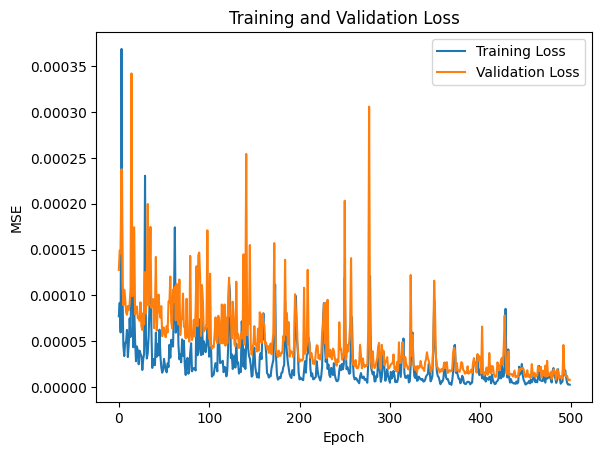

In [11]:
import matplotlib.pyplot as plt

# Get the history of the model's training
history = model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_test, y_test), verbose=0)

# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [13]:
def recommend_vets(desired_specialty):
    # Encode the desired specialty using MultiLabelBinarizer
    desired_specialty_encoded = mlb.transform([[desired_specialty]])
    desired_specialty_encoded_df = pd.DataFrame(desired_specialty_encoded, columns=mlb.classes_)

    filtered_df = pd.DataFrame(columns=df.columns)

    # Loop through each row to check for the desired specialty
    for i in range(len(df)):
        if np.dot(specialties_encoded[i], desired_specialty_encoded.T)[0] > 0:
            filtered_df = pd.concat([filtered_df, df.iloc[[i]]])

    for column in mlb.classes_:
        filtered_df[column] = filtered_df[column].astype(int)

    # Prepare input data for prediction
    input_data = filtered_df.drop(['vet_name','weighted_score'], axis=1).values
    # input_data = filtered_df[['rating','num_rating']].values

    # Predict scores
    scores = model.predict(input_data)

    # Add scores to the filtered dataframe
    filtered_df['score'] = scores.flatten()

    # Get the top N veterinarians
    recommendations = filtered_df.sort_values(by='score', ascending=False)

    # Revert normalization for rating and num_rating before displaying
    recommendations[['rating', 'num_rating']] = scaler.inverse_transform(recommendations[['rating', 'num_rating']])

    # Concatenate the specialties for display
    recommendations['specialties'] = recommendations[mlb.classes_].apply(lambda row: ', '.join(row.index[row.astype(bool)]), axis=1)

    return recommendations[['vet_name', 'specialties', 'rating', 'num_rating', 'score']]

# Example usage
desired_specialty = 'reptile'
top_vets = recommend_vets(desired_specialty)
print(top_vets)


19/19 [==============================] - 0s 2ms/step
    vet_name                             specialties  rating  num_rating  \
261  Vet_595              bird, cattle, pet, reptile     5.0       454.0   
441  Vet_295  aquatic, bird, cattle, exotic, reptile     4.9       477.0   
154  Vet_881           aquatic, exotic, pet, reptile     4.9       452.0   
446  Vet_921          aquatic, bird, exotic, reptile     4.9       443.0   
11   Vet_577      bird, cattle, exotic, pet, reptile     4.8       485.0   
..       ...                                     ...     ...         ...   
628  Vet_716  aquatic, bird, cattle, exotic, reptile     0.2        12.0   
610  Vet_338            cattle, exotic, pet, reptile     0.2         7.0   
936   Vet_36             aquatic, bird, pet, reptile     0.1        82.0   
515  Vet_402     aquatic, bird, exotic, pet, reptile     0.1        72.0   
470  Vet_235              bird, exotic, pet, reptile     0.1        27.0   

        score  
261  0.994089  
44